In [30]:
import os,sys

import numpy as np

import xarray as xr
import time
import pywt

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', 
                       protocol ='tcp://', host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36497 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:36497/status,
Dashboard: http://137.129.155.67:36497/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:33693,Workers: 1
Dashboard: http://137.129.155.67:36497/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:44593,Total threads: 4
Dashboard: http://137.129.155.67:38761/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
from basic_func import *

from multiPr import splitter1D, stitcher1D
from mytools import my_argmax, my_nanmax

In [3]:
def comp_wavelet_mat_omega(mat,x,y,time,dt,wavelet_type,scale_freqcy):
    
    """
    Compute temporal wavelet transform for a matrix with dimensions (t,y,x)
    typically used for the velocity projected on the different vertical modes
    Ubar(t,y,x) or Ucline1(t,y,x), Ucline2(t,y,x) ...

    :return: matrix mhat with dimension (t, PERIODS, y, x) and unit [mat]**2
    """
    periods = 1/(pywt.scale2frequency(wavelet_type,scale_freqcy)/dt)
    
    t0 = time[0]
    tn = time[-1]
    
    mhat = np.nan*np.zeros((time.size,periods.size,y.size,x.size))

    for i in range(len(x)):
        print("nb ", i," on ", len(x))
        for j in range(len(y)):

            vect = mat[:,j,i].values
            
            # apply wavelet transform
            amp, _  = pywt.cwt(vect,scale_freqcy,wavelet_type,sampling_period=dt)
            
            # convert complex amplitude to real ampitude
            mhat[:,:,j,i] = (abs(amp)**2).T

            # remove area outside the cone of influence            
            for p in range(len(periods)):
                mhat[:,p,j,i][time<t0+np.timedelta64(np.int(np.round(periods[p]/2)),'s')] = np.nan
                mhat[:,p,j,i][time>tn-np.timedelta64(np.int(np.round(periods[p]/2)),'s')] = np.nan


    return mhat

def compute_wavelet_mode(indir,mode,var,FourierDim,**kwargs):

    """
    Compute for a given vertical mode (bar or 1, 2, 3 ...etc)
    the wavelet transform along the FourierDim ('time', 'x' or 'y') 
    of the variable var ('u' or 'v') for the experiment exp.
    
    ** options
        - time_avg: false: consider the full time series of ti 
                    true : averga over ti before performing wt.

    :return: netcdf file containing the wavelet power spectrum
    as a function of (time,FourierVar,y,x).
    """
    indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'
    year = 2009
    options={
            'time_avg':False
            }
    
    options.update(kwargs)

    print('Compute '+FourierDim+'-wavelet ')

    data = xr.open_mfdataset(indir_data_FILTERED +  '*' + str(year) + '.nc')
    data = data.sel(lat = slice(-15,15)).persist()
    
    if options['time_avg']==True :
        # average over ti
        mat = data[var+mode].mean('time_counter')
        mat = mat.expand_dims({'time_counter':np.array(['avg'])},axis=0)
    else:
        mat = data[var]
    
    # Variable extraction
    x = np.arange(0,data.lon.size)
    y = np.arange(0,data.lat.size)
    lat = mat.lat.values
    lon = mat.lon.values
    time = mat.time.values
    
    # Resolution
    if options['time_avg']==False:
        dt = np.diff(time).mean().astype('timedelta64[s]').astype('float64') # default: dt=10*86400
        
    print("dt = ", dt)

    dx = np.diff(lon).mean()*deg2m # default: dx=0.25*111000
    dy = np.diff(lat).mean()*deg2m # default: dy=0.25*111000
    
    # define variable name for output netcdf
    namevarf = var+'hat'

    if FourierDim == 'time':
    
        wavelet_type = "cmor1-1.5"
        scale_freqcy = np.arange(30,2101,180)

        fourier_scale = 1/(pywt.scale2frequency(wavelet_type,scale_freqcy)/dt)
        print("fourier scale : ", fourier_scale, "\n")
        mhat = comp_wavelet_mat_omega(mat,x,y,time,dt,wavelet_type,scale_freqcy)
    
        # write to netcdf format
        vhat=xr.Dataset({namevarf:(['time','periods','y','x'],mhat)},
                        coords={'time':time,'periods':fourier_scale,'y':y,'x':x,'lat':lat,'lon':lon})
 
    if FourierDim == 'x':
    
        wavelet_type = "cmor1-1.5"
        scale_freqcy = np.arange(5,200,1)

        fourier_scale = 1/(pywt.scale2frequency(wavelet_type,scale_freqcy)/dx)

        mhat = comp_wavelet_mat_kx(mat,x,y,lon,lat,time,dx,wavelet_type,scale_freqcy)
    
        # write to netcdf format
        vhat=xr.Dataset({namevarf:(['time_counter','xWavelength','y','x'],mhat)},
                        coords={'time_counter':time,'xWavelength':fourier_scale,'y':y,'x':x,'lat':lat,'lon':lon})

    if FourierDim == 'y':
    
        wavelet_type = "cmor1-1.5"
        scale_freqcy = np.arange(5,200,1)

        fourier_scale = 1/(pywt.scale2frequency(wavelet_type,scale_freqcy)/dy)

        mhat = comp_wavelet_mat_ky(mat,x,y,lon,lat,time,dx,wavelet_type,scale_freqcy)
    
        # write to netcdf format
        vhat=xr.Dataset({namevarf:(['time_counter','yWavelength','y','x'],mhat)},coords={'time_counter':time,'yWavelength':fourier_scale,'y':y,'x':x,'lat':lat,'lon':lon})


    vhat.to_netcdf(indir + 'test_Fourier.nc') 
    
    print('DONE : Compute '+FourierDim+'-wavelet')

    return 



In [6]:
### Main Script

indir='/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/'

# Editable section

exp_list=['test']

dim_list=['time']

var_list=['u','v']

varhat_list=['uhat','vhat']


# compute_wavelet_mode(indir,'bar','OLR_Kelvin','time')

# arg_dict = [{'indir':indir,'exp':exp_list[i],'mode':'bar','varhat':'OLRhat','FourierDim':dim_list[j],'ti':'t4'} 
#             for i in range(len(exp_list)) for j in range(len(dim_list)) for k in range(len(var_list))]


In [5]:
wavelet_type = "cmor1-1.5"
scale_freqcy = np.arange(30,2101,90)

1/(pywt.scale2frequency(wavelet_type,scale_freqcy)/10800)

# (1/(pywt.scale2frequency(wavelet_type,scale_freqcy)[-1]/10800))/86400


array([  216000.,   864000.,  1512000.,  2160000.,  2808000.,  3456000.,
        4104000.,  4752000.,  5400000.,  6048000.,  6696000.,  7344000.,
        7992000.,  8640000.,  9288000.,  9936000., 10584000., 11232000.,
       11880000., 12528000., 13176000., 13824000., 14472000., 15120000.])

In [6]:
year = 2009
indir_data_FILTERED = indir
data = xr.open_mfdataset(indir_data_FILTERED +  'test_Fourier.nc')
data


<xarray.Dataset>
Dimensions:        (time: 2920, periods: 12, y: 30, x: 360, lat: 30, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 2009-01-01 ... 2009-12-31T21:00:00
  * periods        (periods) float64 2.16e+05 1.512e+06 ... 1.318e+07 1.447e+07
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * lat            (lat) float32 -14.5 -13.5 -12.5 -11.5 ... 11.5 12.5 13.5 14.5
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    OLR_Kelvinhat  (time, periods, y, x) float64 dask.array<chunksize=(2920, 12, 30, 360), meta=np.ndarray>

In [7]:
def compute_wtFourierMax_mode(varhat,FourierDim_vect):

    """
    Extract the dominant values of the FourierDim from the 
    3d (Dim, FourierDim, Amp) wavelet transform output 
    FourierDim_vect : vector of period or wavelength

    :return: Fmax the table of the value of the fourier variable
    of the maximum power spectrum amplitude at each grid cell (t,i,j) 
    and Famp the amplitude of the maximum.
    """

    time_size = varhat.shape[0]
    y_size = varhat.shape[2]
    x_size = varhat.shape[3]

    Fmax = np.nan*np.zeros((time_size,y_size,x_size))
    Famp = np.nan*np.zeros((time_size,y_size,x_size))
    
    for t in range(time_size):
        if t%(time_size/5)==0 :
            print('t ',t,' on ',time_size)
        for i in range(x_size):
            for j in range(y_size):

                try:
                    amp_max = my_nanmax(varhat[t,:,j,i],0)
                    ind_max = my_argmax(varhat[t,:,j,i],0)

                    Fmax[t,j,i] = FourierDim_vect[ind_max] 
                    Famp[t,j,i] = amp_max

                except:
                    # all nan values.
                    pass


    return Fmax, Famp


def wtMax2nc(indir,varhat,FourierDim,**kwargs):

    """
    Extract the values of the fourier dimension FourierDim ('time', 'x' or 'y')
    for the maximum wavelet power spectrum of variable varhat ('uhat' or 'vhat')
    projected on the vertical mode mode ('bar', 'cline1', 'cline2' ...etc) for 
    the experiment exp over the period ti.
    ! parallel computing 
    
    **options:
        - time_avg: True or False: consider the averaged 
                    or full time series wavelet transform.

    call: compute_wtFourierMax_mode

    :return: netcdf file with 
    """

    options={
       'time_avg':False
    }

    options.update(kwargs)

    data = xr.open_dataset(indir+'test_Fourier.nc')
    data = data.isel(time = slice(0,None,4))
    
    # Extract variables

    varh=data[varhat].values
    
    if (FourierDim=='x') :
        FourierDim_vect=data['xWavelength'].values
        namevar='KXmax'
    if (FourierDim=='y') :
        FourierDim_vect=data['yWavelength'].values
        namevar='KYmax'
    if FourierDim=='time':
        FourierDim_vect=data['periods'].values
        namevar='Pmax'

    x = np.arange(0,data.lon.size)
    y = np.arange(0,data.lat.size)
    lat = data.lat.values
    lon = data.lon.values
    time = data.time.values

    # Preprocess parallel computing: split
    
    nblocks, dims = (time.size),(0)
    output = compute_wtFourierMax_mode(varh,FourierDim_vect)
    print('shape output ', np.shape(output))
    print('y length = ', data.lat.size)
    print('y = ',y)
    print('x length = ', data.lon.size)

    
    Fmax = output[0]
    Famp = output[1]

    # write to netcdf
    kmax = xr.Dataset({namevar:(['time','y','x'],Fmax),'amp':(['time','y','x'],Famp)},
                      coords={'time':time,'x':x,'y':y,'lon':lon,'lat':lat})
    kmax.to_netcdf(indir+'test_max.nc')

    return



In [8]:
wtMax2nc(indir,'OLR_Kelvinhat','time')

t  0  on  730


tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199269' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199305' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

t  146  on  730


tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199377' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199433' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199501' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

t  292  on  730


tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199544' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199604' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199661' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 265, in connect
    addrinfo = await self.resolver.resolve(host, port, af)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel

t  438  on  730


tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199712' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199779' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199831' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 265, in connect
    addrinfo = await self.resolver.resolve(host, port, af)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199884' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

t  584  on  730


tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199904' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-199964' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f07c4437400>>, <Task finished name='Task-200019' coro=<Cluster._sync_cluster_info() done, defined at /home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:36873 after 30 s')>)
Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/durandy/miniconda3

shape output  (2, 730, 30, 360)
y length =  30
y =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
x length =  360


In [7]:
ds = xr.open_mfdataset(indir+'test_max.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 730, y: 30, x: 360, lon: 360, lat: 30)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 ... 2009-12-31T12:00:00
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 20 21 22 23 24 25 26 27 28 29
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
Data variables:
    Pmax     (time, y, x) float64 dask.array<chunksize=(730, 30, 360), meta=np.ndarray>
    amp      (time, y, x) float64 dask.array<chunksize=(730, 30, 360), meta=np.ndarray>

In [8]:
_ds = ds.sum(dim = 'time')
# _ds = _ds.sum(dim = 'x')
_ds['x'] = _ds['lon'].values
_ds['y'] = _ds['lat'].values

_ds

<xarray.Dataset>
Dimensions:  (y: 30, x: 360, lon: 360, lat: 30)
Coordinates:
  * x        (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
Data variables:
    Pmax     (y, x) float64 dask.array<chunksize=(30, 360), meta=np.ndarray>
    amp      (y, x) float64 dask.array<chunksize=(30, 360), meta=np.ndarray>

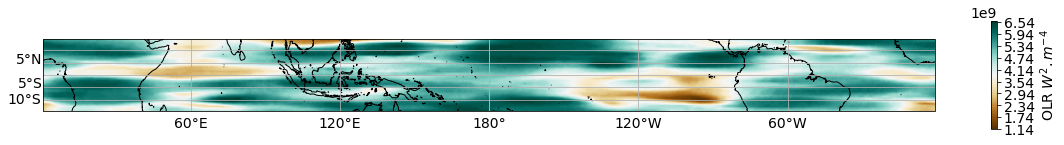

In [11]:
import cartopy.crs as ccrs
import cartopy
from matplotlib import pyplot as plt

plt.rc("font", size=14)


map_proj = ccrs.Mercator(central_longitude=180.0, 
                         min_latitude=-15.1, 
                         max_latitude=15.1,
                         globe=None)

plt.rc("figure", figsize=(20,2))
cmap ='BrBG'
vmin, vmax = -10, +10

colorbar = {'label': 'OLR $W^{2}.m^{-4}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}



fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})
_ds['Pmax'].plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , 
                    cbar_kwargs=colorbar)
axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.show()

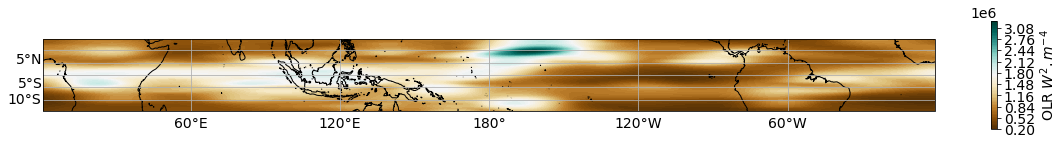

In [12]:
import cartopy.crs as ccrs
import cartopy
from matplotlib import pyplot as plt

plt.rc("font", size=14)


map_proj = ccrs.Mercator(central_longitude=180.0, 
                         min_latitude=-30.1, 
                         max_latitude=30.1,
                         globe=None)

cmap ='BrBG'
vmin, vmax = -10, +10

colorbar = {'label': 'OLR $W^{2}.m^{-4}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}



fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})
_ds['amp'].plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , 
                    cbar_kwargs=colorbar)
axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.show()

In [15]:
__ds = xr.open_mfdataset(indir +  'test_Fourier.nc')
__ds

<xarray.Dataset>
Dimensions:        (time: 2920, periods: 12, y: 30, x: 360, lat: 30, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 2009-01-01 ... 2009-12-31T21:00:00
  * periods        (periods) float64 2.16e+05 1.512e+06 ... 1.318e+07 1.447e+07
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * lat            (lat) float32 -14.5 -13.5 -12.5 -11.5 ... 11.5 12.5 13.5 14.5
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    OLR_Kelvinhat  (time, periods, y, x) float64 dask.array<chunksize=(2920, 12, 30, 360), meta=np.ndarray>

In [16]:
_ds = ds.sel(time = slice('2009-08-20','2009-09-10')) 

In [18]:
_ds = _ds.sum(dim = 'time')
# _ds = _ds.sum(dim = 'x')
_ds['x'] = _ds['lon'].values
_ds['y'] = _ds['lat'].values

_ds

<xarray.Dataset>
Dimensions:  (y: 30, x: 360, lon: 360, lat: 30)
Coordinates:
  * x        (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
Data variables:
    Pmax     (y, x) float64 dask.array<chunksize=(30, 360), meta=np.ndarray>
    amp      (y, x) float64 dask.array<chunksize=(30, 360), meta=np.ndarray>

In [19]:
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-0.1, 
                         max_latitude=15.1,
                         globe=None)

plt.rc("figure", figsize=(20,2))
cmap ='BrBG'

<xarray.Dataset>
Dimensions:  (y: 30, x: 60, lon: 360, lat: 30)
Coordinates:
  * x        (x) float32 300.5 301.5 302.5 303.5 ... 356.5 357.5 358.5 359.5
  * y        (y) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -14.5 -13.5 -12.5 -11.5 -10.5 ... 11.5 12.5 13.5 14.5
Data variables:
    Pmax     (y, x) float64 dask.array<chunksize=(30, 60), meta=np.ndarray>
    amp      (y, x) float64 dask.array<chunksize=(30, 60), meta=np.ndarray>

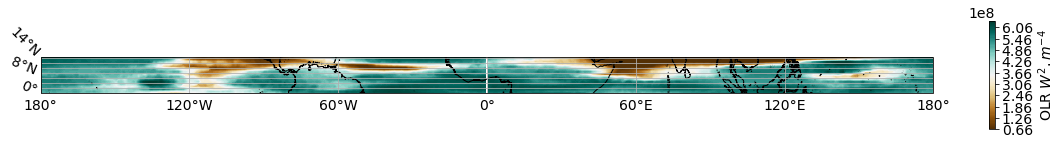

In [29]:
fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})
_ds['Pmax'].plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , 
                    cbar_kwargs=colorbar)
axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.show()